# Model Development: Titanic-Spaceship <span style="color:orange">**Competition**</span>
<img src="../assets/spaceship-pic.jpg" alt="Title-Pic">

# Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from datetime import datetime
from pandas import Series, DataFrame
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (10, 6), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})

# Data

In [20]:
MODEL_DATA = np.load("../model_data/titanic_spaceship_prep_data1.npz", allow_pickle=True)
inputs = MODEL_DATA["inputs"]
targets = MODEL_DATA["targets"]
DATA_COLUMN_NAMES = MODEL_DATA["input_column_names"]

X_train, X_tmp_test, y_train, y_tmp_test = train_test_split(inputs, targets, test_size=0.2, random_state=101)
X_test, X_val, y_test, y_val = train_test_split(X_tmp_test, y_tmp_test, test_size=0.5, random_state=101)

(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((7004, 22), (876, 22), (876, 22)), ((7004,), (876,), (876,)))

# Helper Functions

In [21]:
def export_model(model, model_name):
    timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")
    export_path = f"../trained_models/{timestamp_string}_{model_name}"
    with open(export_path, "wb") as model_file:
        pickle.dump(model, model_file)
    
    return export_path

In [22]:
def load_model(model_path):
    with open(model_path, "rb") as model_file:
        return pickle.load(model_file)

In [23]:
def print_top_rankings(cv_results, top=10):
    sorted_zipped_report = sorted(
        zip(
            cv_results["params"], 
            cv_results["mean_test_score"], 
            cv_results["rank_test_score"]
        ), key=lambda item: item[2]
    )
    for (i, (params, score, rank)) in enumerate(sorted_zipped_report):
        if i >= top:
            break

        print(f"Rank: {rank}\tScore: {score}\nParam: {params}\n")
        

In [24]:
def print_model_classification_report(model, X_data, y_data):
    preds_test = model.predict(X_data)
    preds_train = model.predict(X_train)

    f1_score_test = f1_score(y_data, preds_test, average="macro")
    accuracy_score_test = accuracy_score(y_data, preds_test)
    f1_score_train = f1_score(y_train, preds_train, average="macro")
    accuracy_score_train = accuracy_score(y_train, preds_train)

    print(f"Accuracy:\t{f1_score_test}\t|\tTrain-Accuracy:\t{accuracy_score_train}")
    print(f"F1-Score:\t{accuracy_score_test}\t|\tTrain-F1-Score:\t{f1_score_train}\n")
    print(classification_report(y_data, preds_test))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_data, preds_test), annot=True, cmap="cool", fmt='.5g')


In [25]:
def print_feature_importance(model):
    return Series(data=model.feature_importances_, index=DATA_COLUMN_NAMES).sort_values(ascending=False)

# Build the Model

## Model1: GradientBoost XGB Model

### Basic Model

In [26]:
xgb_model = XGBClassifier(nthread=-1)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

Accuracy:	0.7932105729239349	|	Train-Accuracy:	0.8732153055396916
F1-Score:	0.79337899543379	|	Train-F1-Score:	0.8728169148183302

              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79       441
         1.0       0.77      0.83      0.80       435

    accuracy                           0.79       876
   macro avg       0.79      0.79      0.79       876
weighted avg       0.79      0.79      0.79       876



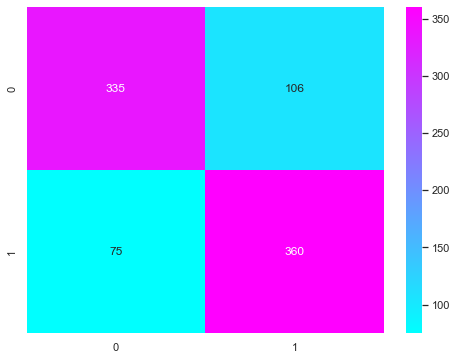

In [27]:
print_model_classification_report(xgb_model, X_test, y_test)

In [28]:
print_feature_importance(xgb_model)

CryoSleep                    0.614865
HomePlanet_Earth             0.124234
HomePlanet_Europa            0.054895
Cabin_E                      0.030059
Spa                          0.015633
VRDeck                       0.015285
RoomService                  0.014993
FoodCourt                    0.013783
ShoppingMall                 0.012742
HomePlanet_Mars              0.011426
Destination_PSO J318.5-22    0.011277
Cabin_F                      0.011063
Cabin_D                      0.010120
Age                          0.008935
VIP                          0.008376
Cabin_C                      0.008103
Cabin_G                      0.007733
Destination_55 Cancri e      0.007531
Destination_TRAPPIST-1e      0.006740
Cabin_B                      0.006216
Cabin_A                      0.005992
Cabin_T                      0.000000
dtype: float32

In [29]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'nthread': -1}

### GridModel

In [49]:
xgb_tmp_model = XGBClassifier(nthread=-1,)

xgb_grid_params = {
    "eval_metric": ["logloss"],
    "learning_rate": [0.05],
    "min_child_weight": [3],
    "n_estimators": np.arange(95, 200, 1),
    "eta": [0.05],
    "gamma": [1],
    "subsample": [0.6],
    "max_depth": [3],
    "colsample_bytree": [0.5]
}

In [50]:
xgb_grid_model = GridSearchCV(xgb_tmp_model, xgb_grid_params, cv=2, scoring="accuracy", verbose=3)

xgb_grid_model.fit(X_train, y_train)

Fitting 2 folds for each of 105 candidates, totalling 210 fits
[CV 1/2] END colsample_bytree=0.5, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=95, subsample=0.6;, score=0.789 total time=   0.1s
[CV 2/2] END colsample_bytree=0.5, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=95, subsample=0.6;, score=0.776 total time=   0.1s
[CV 1/2] END colsample_bytree=0.5, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=96, subsample=0.6;, score=0.789 total time=   0.1s
[CV 2/2] END colsample_bytree=0.5, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=96, subsample=0.6;, score=0.776 total time=   0.1s
[CV 1/2] END colsample_bytree=0.5, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=97, subsample=0.6;, score=0.

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199]),
                         'subsample': [0.6]},
             scoring='accuracy', verbose=3)

Accuracy:	0.8012662716955941	|	Train-Accuracy:	0.7985436893203883
F1-Score:	0.8013698630136986	|	Train-F1-Score:	0.7982189006668532

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.80       441
         1.0       0.78      0.83      0.81       435

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876



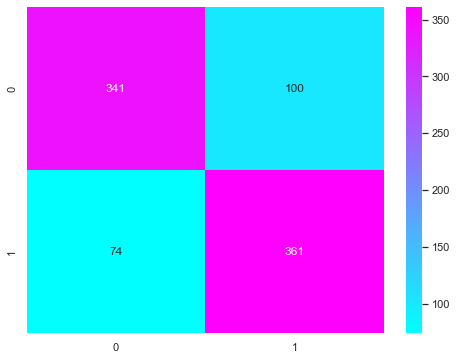

In [51]:
print_model_classification_report(xgb_grid_model, X_test, y_test)

In [52]:
print_top_rankings(xgb_grid_model.cv_results_, 50)

Rank: 1	Score: 0.789548829240434
Param: {'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 146, 'subsample': 0.6}

Rank: 2	Score: 0.7894060536836094
Param: {'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 149, 'subsample': 0.6}

Rank: 2	Score: 0.7894060536836094
Param: {'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 189, 'subsample': 0.6}

Rank: 4	Score: 0.7892632781267848
Param: {'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 145, 'subsample': 0.6}

Rank: 5	Score: 0.7892632781267847
Param: {'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'le

### Best Model Selection

In [ ]:
xgb_best_model = "err"

## Model2: KNearestNeighbor KNN

### Basic Model

Accuracy:	0.7604010851599274	|	Train-Accuracy:	0.7815533980582524
F1-Score:	0.7614155251141552	|	Train-F1-Score:	0.7808096093823892

              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78       441
         1.0       0.79      0.70      0.74       435

    accuracy                           0.76       876
   macro avg       0.77      0.76      0.76       876
weighted avg       0.76      0.76      0.76       876



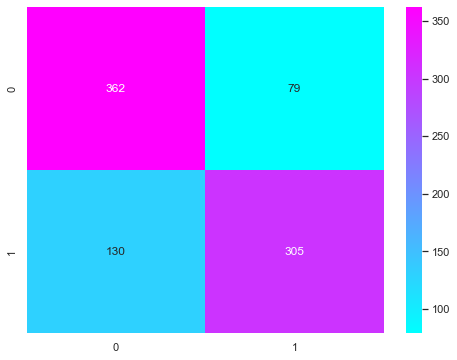

In [53]:
knn_model = KNeighborsClassifier(21) #21 -> 80,249
knn_model.fit(X_train, y_train)
print_model_classification_report(knn_model, X_test, y_test)

### GridModel

In [54]:
knn_tmp_model = KNeighborsClassifier()

knn_grid_params = {
    "n_neighbors": np.arange(3, 50, 1),
    "metric": ["manhattan"],
    "weights": ["distance"]
}

In [55]:
knn_grid_model = GridSearchCV(knn_tmp_model, knn_grid_params, cv=3, scoring="accuracy", verbose=3)

knn_grid_model.fit(X_train, y_train)

Fitting 3 folds for each of 47 candidates, totalling 141 fits
[CV 1/3] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.737 total time=   0.1s
[CV 2/3] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.742 total time=   0.1s
[CV 3/3] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.746 total time=   0.0s
[CV 1/3] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.735 total time=   0.0s
[CV 2/3] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.709 total time=   0.0s
[CV 3/3] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.726 total time=   0.0s
[CV 1/3] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.760 total time=   0.0s
[CV 2/3] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.741 total time=   0.0s
[CV 3/3] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.746 total time=   0.1s
[CV 1/3] END metric=manhattan, n_neighbors=6, weights=distance;, score=0.7

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan'],
                         'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'weights': ['distance']},
             scoring='accuracy', verbose=3)

Accuracy:	0.780161867118389	|	Train-Accuracy:	0.9076242147344374
F1-Score:	0.7808219178082192	|	Train-F1-Score:	0.9076130486781808

              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79       441
         1.0       0.81      0.73      0.77       435

    accuracy                           0.78       876
   macro avg       0.78      0.78      0.78       876
weighted avg       0.78      0.78      0.78       876



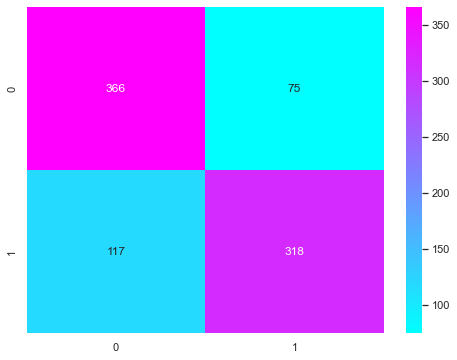

In [56]:
print_model_classification_report(knn_grid_model, X_test, y_test)

In [42]:
print_top_rankings(knn_grid_model.cv_results_, 20)

Rank: 1	Score: 0.7764134780125642
Param: {'metric': 'manhattan', 'n_neighbors': 48, 'weights': 'distance'}

Rank: 2	Score: 0.7756996002284409
Param: {'metric': 'manhattan', 'n_neighbors': 46, 'weights': 'distance'}

Rank: 3	Score: 0.7755568246716162
Param: {'metric': 'manhattan', 'n_neighbors': 49, 'weights': 'distance'}

Rank: 4	Score: 0.7754140491147916
Param: {'metric': 'manhattan', 'n_neighbors': 43, 'weights': 'distance'}

Rank: 5	Score: 0.7752712735579669
Param: {'metric': 'manhattan', 'n_neighbors': 41, 'weights': 'distance'}

Rank: 5	Score: 0.7752712735579669
Param: {'metric': 'manhattan', 'n_neighbors': 42, 'weights': 'distance'}

Rank: 7	Score: 0.7751284980011423
Param: {'metric': 'manhattan', 'n_neighbors': 47, 'weights': 'distance'}

Rank: 8	Score: 0.7751284980011421
Param: {'metric': 'manhattan', 'n_neighbors': 44, 'weights': 'distance'}

Rank: 9	Score: 0.7749857224443175
Param: {'metric': 'manhattan', 'n_neighbors': 36, 'weights': 'distance'}

Rank: 10	Score: 0.7748429468

### Best Model Selection

In [ ]:
knn_best_model = "err"

## Model3: RandomForest

### Basic Model

Accuracy:	0.812432435255349	|	Train-Accuracy:	0.9073386636207881
F1-Score:	0.8127853881278538	|	Train-F1-Score:	0.906490627135635

              precision    recall  f1-score   support

         0.0       0.85      0.76      0.80       441
         1.0       0.78      0.86      0.82       435

    accuracy                           0.81       876
   macro avg       0.82      0.81      0.81       876
weighted avg       0.82      0.81      0.81       876



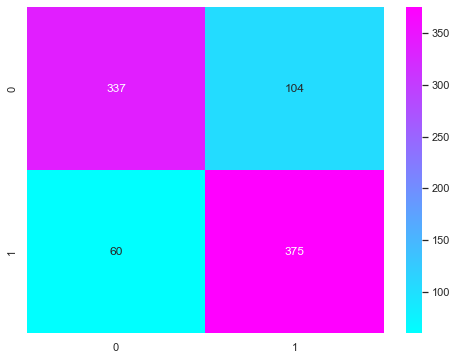

In [84]:
rf_model = RandomForestClassifier(n_estimators=320, random_state=101) # 320 -> 81.24
rf_model.fit(X_train, y_train)
print_model_classification_report(rf_model, X_test, y_test)

### GridModel

In [57]:
rf_tmp_model = RandomForestClassifier()

rf_grid_params = {
    "criterion": ["gini"],
    "max_depth": np.arange(7, 15, 1),
    "min_samples_split": [2, 3],
    "min_samples_leaf": [2, 3],

    # BaggingClassifier params
    "n_estimators": np.arange(90, 120, 2),
    "max_samples": [0.8],
    "bootstrap": [True]
}

In [58]:
rf_grid_model = GridSearchCV(rf_tmp_model, rf_grid_params, cv=2, scoring="accuracy", verbose=3)

rf_grid_model.fit(X_train, y_train)

Fitting 2 folds for each of 480 candidates, totalling 960 fits
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=90;, score=0.791 total time=   0.1s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=90;, score=0.774 total time=   0.1s
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=92;, score=0.789 total time=   0.1s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=92;, score=0.772 total time=   0.1s
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=94;, score=0.792 total time=   0.1s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=7, max_samples=0.8, min_samples_leaf=2, min_samples_split

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': array([ 7,  8,  9, 10, 11, 12, 13, 14]),
                         'max_samples': [0.8], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': array([ 90,  92,  94,  96,  98, 100, 102, 104, 106, 108, 110, 112, 114,
       116, 118])},
             scoring='accuracy', verbose=3)

Accuracy:	0.7990354284522536	|	Train-Accuracy:	0.8338092518560822
F1-Score:	0.7990867579908676	|	Train-F1-Score:	0.8336480951097209

              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80       441
         1.0       0.78      0.82      0.80       435

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876



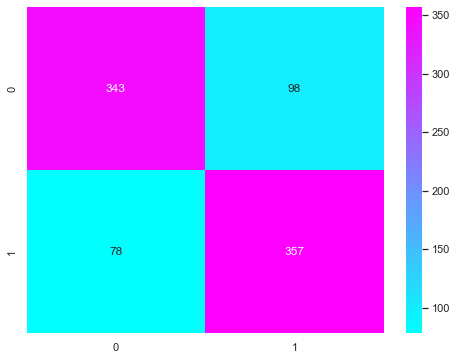

In [59]:
print_model_classification_report(rf_grid_model, X_test, y_test)

In [60]:
print_top_rankings(rf_grid_model.cv_results_, 20)

Rank: 1	Score: 0.7902627070245574
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 12, 'max_samples': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 118}

Rank: 2	Score: 0.7899771559109081
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_samples': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 110}

Rank: 2	Score: 0.7899771559109081
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 14, 'max_samples': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}

Rank: 4	Score: 0.789548829240434
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 11, 'max_samples': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 104}

Rank: 5	Score: 0.7892632781267848
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 11, 'max_samples': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 110}

Rank: 6	Score: 0.78912050256996
Param: {'bootstrap': True, 'c

### Best Model Selection

In [ ]:
rf_best_model = "err"

## Model4 - Support Vector Machine SVM

### Basic Model

Accuracy:	0.7852762016021362	|	Train-Accuracy:	0.7988292404340377
F1-Score:	0.7853881278538812	|	Train-F1-Score:	0.7985986364406403

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78       441
         1.0       0.77      0.81      0.79       435

    accuracy                           0.79       876
   macro avg       0.79      0.79      0.79       876
weighted avg       0.79      0.79      0.79       876



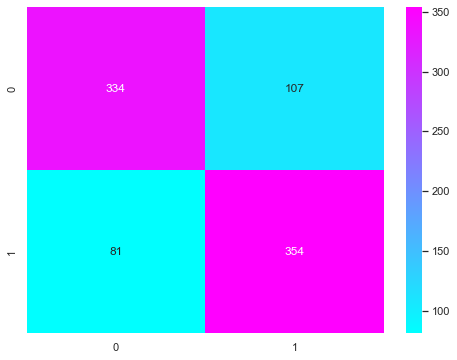

In [61]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
print_model_classification_report(svm_model, X_test, y_test)

### GridModel

In [62]:
svm_tmp_model = SVC(probability=True)

svm_grid_params = {
    "C": [5],
    "gamma": ["auto"],
    "kernel": ["poly"],
    "degree": [1, 2, 3],
    "coef0": [1]
}

In [63]:
svm_grid_model = GridSearchCV(svm_tmp_model, svm_grid_params, cv=2, scoring="accuracy", verbose=3)

svm_grid_model.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END C=5, coef0=1, degree=1, gamma=auto, kernel=poly;, score=0.770 total time=   0.8s
[CV 2/2] END C=5, coef0=1, degree=1, gamma=auto, kernel=poly;, score=0.763 total time=   0.8s
[CV 1/2] END C=5, coef0=1, degree=2, gamma=auto, kernel=poly;, score=0.791 total time=   0.8s
[CV 2/2] END C=5, coef0=1, degree=2, gamma=auto, kernel=poly;, score=0.780 total time=   0.8s
[CV 1/2] END C=5, coef0=1, degree=3, gamma=auto, kernel=poly;, score=0.788 total time=   0.9s
[CV 2/2] END C=5, coef0=1, degree=3, gamma=auto, kernel=poly;, score=0.777 total time=   0.9s


GridSearchCV(cv=2, estimator=SVC(probability=True),
             param_grid={'C': [5], 'coef0': [1], 'degree': [1, 2, 3],
                         'gamma': ['auto'], 'kernel': ['poly']},
             scoring='accuracy', verbose=3)

Accuracy:	0.782913786357115	|	Train-Accuracy:	0.7944031981724728
F1-Score:	0.7831050228310502	|	Train-F1-Score:	0.7940549859726994

              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78       441
         1.0       0.76      0.82      0.79       435

    accuracy                           0.78       876
   macro avg       0.78      0.78      0.78       876
weighted avg       0.78      0.78      0.78       876



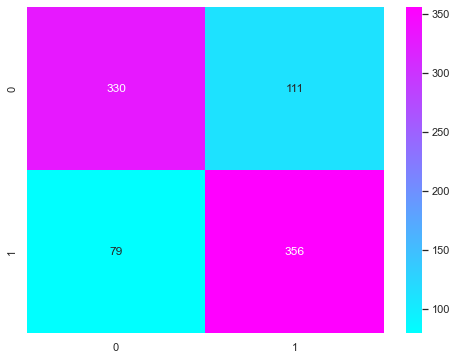

In [64]:
print_model_classification_report(svm_grid_model, X_test, y_test)

In [65]:
print_top_rankings(svm_grid_model.cv_results_, 20)

Rank: 1	Score: 0.7855511136493433
Param: {'C': 5, 'coef0': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}

Rank: 2	Score: 0.7826956025128498
Param: {'C': 5, 'coef0': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

Rank: 3	Score: 0.7664191890348373
Param: {'C': 5, 'coef0': 1, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}



### Best Model Selection

In [ ]:
svm_best_model = "err"

## Model5 - DecisionTree

### Basic Model

Accuracy:	0.7628624293013182	|	Train-Accuracy:	0.9073386636207881
F1-Score:	0.7648401826484018	|	Train-F1-Score:	0.9064957513805084

              precision    recall  f1-score   support

         0.0       0.83      0.67      0.74       441
         1.0       0.72      0.86      0.78       435

    accuracy                           0.76       876
   macro avg       0.78      0.77      0.76       876
weighted avg       0.78      0.76      0.76       876



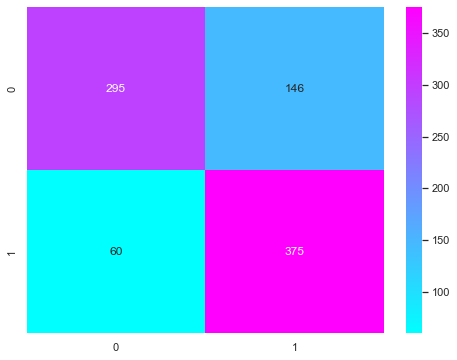

In [98]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
print_model_classification_report(dt_model, X_test, y_test)

In [ ]:
dt_best_model = dt_model

## Model6 - EnsembleModel1 -> VotingClassifier

In [99]:
estimators_c1 = [
    ("rf", rf_model),
    ("knn", knn_model),
    ("xgb", xgb_model),
    ("svm", svm_model),
    ("dt", dt_model)
]

estimators_c2 = [
    ("rf", rf_model),
    ("knn", knn_model),
    ("xgb", xgb_model),
    ("svm", svm_model)
]

estimators_c3 = [
    ("rf", rf_model),
    ("knn", knn_model),
    ("svm", svm_model)
]

estimators_c4 = [
    ("rf", rf_model),
    ("knn", knn_model),
    ("xgb", xgb_model)
]

estimators_c5 = [
    ("rf", rf_model),
    ("knn", knn_model)
]

In [105]:
vc_model1 = VotingClassifier(estimators=estimators_c1, voting="soft")
vc_model2 = VotingClassifier(estimators=estimators_c2, voting="soft")
vc_model3 = VotingClassifier(estimators=estimators_c3, voting="soft")
vc_model4 = VotingClassifier(estimators=estimators_c4, voting="soft")
vc_model5 = VotingClassifier(estimators=estimators_c5, voting="soft")

vc_model1.fit(X_train, y_train)
vc_model2.fit(X_train, y_train)
vc_model3.fit(X_train, y_train)
vc_model4.fit(X_train, y_train)
vc_model5.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=320,
                                                     random_state=101)),
                             ('knn', KNeighborsClassifier(n_neighbors=21))],
                 voting='soft')

Accuracy:	0.8025090992966859	|	Train-Accuracy:	0.8823529411764706
F1-Score:	0.8025114155251142	|	Train-F1-Score:	0.8822214775701687

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       441
         1.0       0.80      0.81      0.80       435

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876

Accuracy:	0.8082101806239737	|	Train-Accuracy:	0.8395202741290692
F1-Score:	0.8082191780821918	|	Train-F1-Score:	0.8394777483115844

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       441
         1.0       0.81      0.81      0.81       435

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876

Accuracy:	0.8093545196396434	|	Train-Accuracy:	0.8306681896059395
F1-Score:	0.80

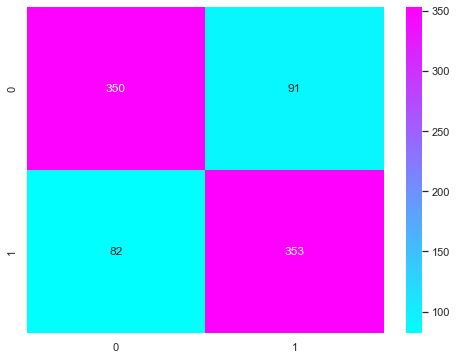

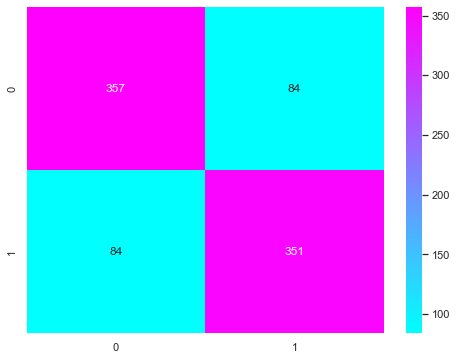

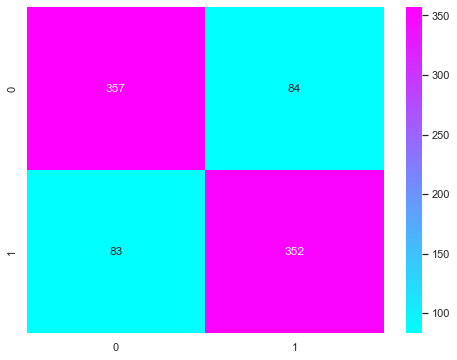

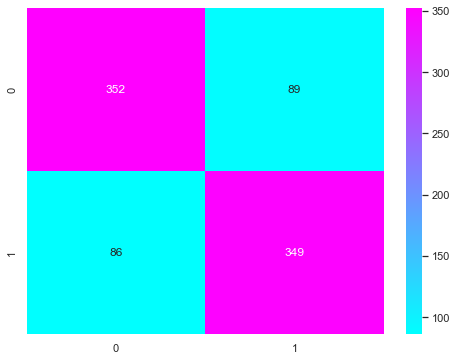

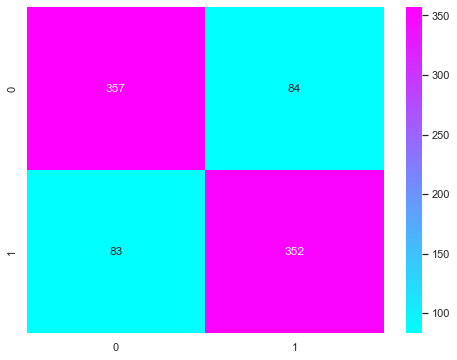

In [106]:
print_model_classification_report(vc_model1, X_test, y_test)
print_model_classification_report(vc_model2, X_test, y_test)
print_model_classification_report(vc_model3, X_test, y_test)
print_model_classification_report(vc_model4, X_test, y_test)
print_model_classification_report(vc_model5, X_test, y_test)

In [66]:
grid_estimators_c1 = [
    ("svm", svm_grid_model.best_estimator_),
    ("rf", rf_grid_model.best_estimator_),
    ("xgb", xgb_grid_model.best_estimator_),
    ("knn", knn_grid_model.best_estimator_),
]

grid_estimators_c2 = [
    ("rf", rf_grid_model.best_estimator_),
    ("svm", svm_grid_model.best_estimator_),
    ("knn", knn_grid_model.best_estimator_),
]

grid_estimators_c3 = [
    ("svm", svm_grid_model.best_estimator_),
    ("rf", rf_grid_model.best_estimator_),
    ("xgb", xgb_grid_model.best_estimator_),
]

In [67]:
vc_grid_model1 = VotingClassifier(estimators=grid_estimators_c1, voting="soft")
vc_grid_model2 = VotingClassifier(estimators=grid_estimators_c2, voting="soft")
vc_grid_model3 = VotingClassifier(estimators=grid_estimators_c3, voting="soft")

vc_grid_model1.fit(X_train, y_train)
vc_grid_model2.fit(X_train, y_train)
vc_grid_model3.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(C=5, coef0=1, degree=2, gamma='auto',
                                  kernel='poly', probability=True)),
                             ('rf',
                              RandomForestClassifier(max_depth=12,
                                                     max_samples=0.8,
                                                     min_samples_leaf=3,
                                                     min_samples_split=3,
                                                     n_estimators=118)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.5...
                                            eval_metric='logloss', gamma=1,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.05, max_bin=256,
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=3,
                                            max_leaves=0, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=146, n_jobs=-1,
                                            nthread=-1, num_parallel_tree=1,
                                            predictor='auto', random_state=0, ...))],
                 voting='soft')

Accuracy:	0.817327793388559	|	Train-Accuracy:	0.8666476299257567
F1-Score:	0.817351598173516	|	Train-F1-Score:	0.8664802294591689

              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82       444
         1.0       0.80      0.84      0.82       432

    accuracy                           0.82       876
   macro avg       0.82      0.82      0.82       876
weighted avg       0.82      0.82      0.82       876

Accuracy:	0.8150598170302605	|	Train-Accuracy:	0.8853512278697887
F1-Score:	0.815068493150685	|	Train-F1-Score:	0.8850756094906068

              precision    recall  f1-score   support

         0.0       0.83      0.80      0.81       444
         1.0       0.80      0.83      0.82       432

    accuracy                           0.82       876
   macro avg       0.82      0.82      0.82       876
weighted avg       0.82      0.82      0.82       876

Accuracy:	0.8139150583779796	|	Train-Accuracy:	0.8113934894346088
F1-Score:	0.81392

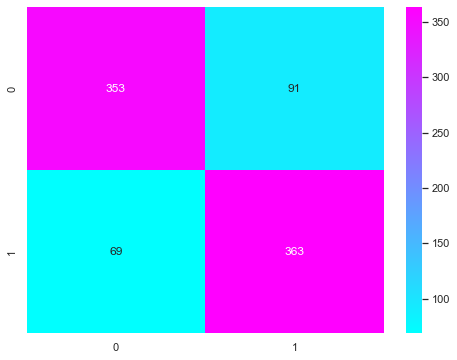

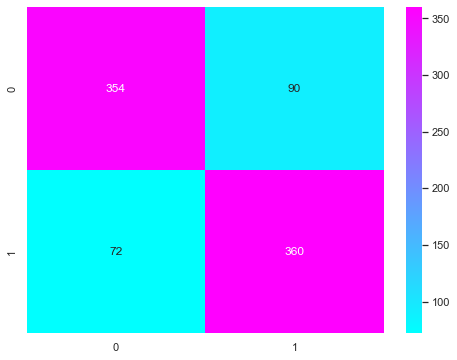

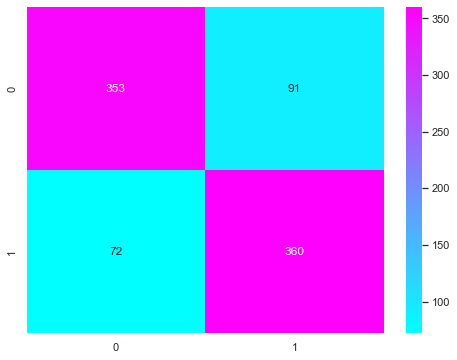

In [68]:
print_model_classification_report(vc_grid_model1, X_val, y_val)
print_model_classification_report(vc_grid_model2, X_val, y_val)
print_model_classification_report(vc_grid_model3, X_val, y_val)

80.93%

Accuracy:	0.814990378748768	|	Train-Accuracy:	0.7985436893203883
F1-Score:	0.815068493150685	|	Train-F1-Score:	0.7982189006668532

              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       444
         1.0       0.79      0.85      0.82       432

    accuracy                           0.82       876
   macro avg       0.82      0.82      0.81       876
weighted avg       0.82      0.82      0.81       876

Accuracy:	0.813839364288834	|	Train-Accuracy:	0.7944031981724728
F1-Score:	0.8139269406392694	|	Train-F1-Score:	0.7940549859726994

              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       444
         1.0       0.79      0.85      0.82       432

    accuracy                           0.81       876
   macro avg       0.82      0.81      0.81       876
weighted avg       0.82      0.81      0.81       876

Accuracy:	0.8104983319432861	|	Train-Accuracy:	0.8338092518560822
F1-Score:	0.81050

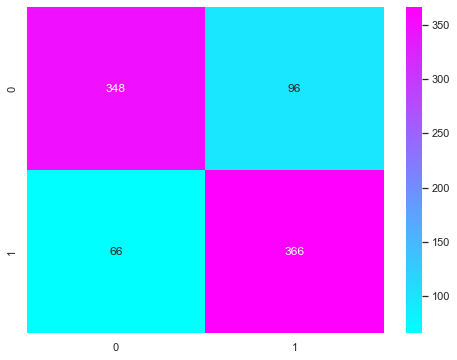

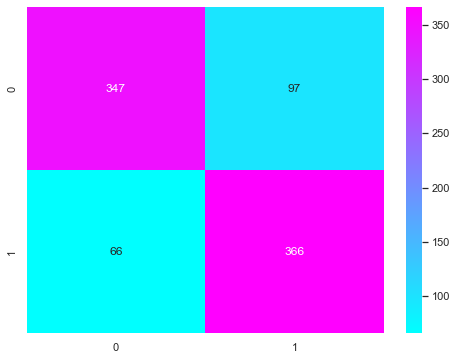

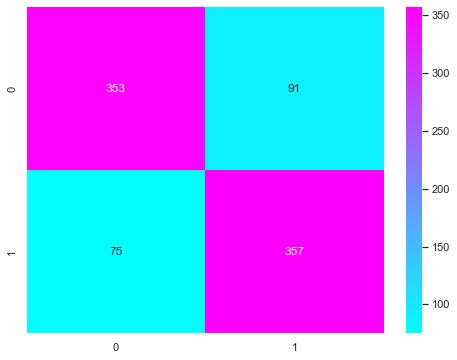

In [88]:
print_model_classification_report(xgb_grid_model.best_estimator_, X_val, y_val)
print_model_classification_report(svm_grid_model.best_estimator_, X_val, y_val)
print_model_classification_report(rf_grid_model.best_estimator_, X_val, y_val)

# Final Model Selection

# Create Submissions

In [83]:
def get_submission_csv_df(model, test_data_path):
    df_test_data = pd.read_csv(test_data_path)
    preds = Series(model.predict(df_test_data.drop(columns=["PassengerId"]).to_numpy())).map({0: False, 1: True})
    return DataFrame({"PassengerId": df_test_data["PassengerId"].to_numpy(), "Transported": preds})

def save_submissions(df, csv_name):
    df.to_csv(f"../submissions/{csv_name}.csv", index=False)

In [82]:
pd.read_csv("../model_data/submission_test_data1.csv")["PassengerId"]

0       0013_01
1       0018_01
2       0019_01
3       0021_01
4       0023_01
         ...   
4272    9266_02
4273    9269_01
4274    9271_01
4275    9273_01
4276    9277_01
Name: PassengerId, Length: 4277, dtype: object

In [70]:
TEST_PATH = "../model_data/submission_test_data1.csv"

In [76]:
submission1 = get_submission_csv_df(vc_grid_model2, "../model_data/submission_test_data3.csv")
submission1

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [ ]:
save_submissions(submission1, "vc_grid_model2")

In [84]:
submission2 = get_submission_csv_df(vc_grid_model1, TEST_PATH) # BEST -> 79.9939%
submission2

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [85]:
save_submissions(submission2, "vc_grid_model1")

In [81]:
submission3 = get_submission_csv_df(svm_grid_model.best_estimator_, TEST_PATH)
submission3

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [82]:
save_submissions(submission3, "svm")


In [85]:
submission4 = get_submission_csv_df(rf_model, TEST_PATH)
submission4

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [86]:
save_submissions(submission3, "rf")


# Export the Model

In [ ]:
rf_model